# Spark SQL and DataFrames for Peak ODS Server

In this example Notebook, we show you how to use the Peak ODS Adapter for Apache Spark to interact with ODS data using Spark SQL and DataFrames.

The first section is on configuring the Spark framework and the Peak ODS Adapter for Apache Spark. The fun starts with "Working with Peak ODS Adapter for Apache Spark".

Happy sparking!



## Initialize Spark





### Configure Spark

Initialize the Spark context and configure it for using the Peak ODS Adapter for Apache Spark as plugin. 

In this example we create and connect to a local Spark Master.



In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().set("spark.jars", "/target/spark-ods.jar")
conf.set("spark.sql.repl.eagerEval.enabled",True)
conf.set("spark.plugins", "com.peaksolution.sparkods.ods.SparkOdsPlugin")
conf.set("spark.odsplugin.host", "fls-test")

spark = SparkSession.builder.master('local[*]').config(conf = conf).getOrCreate() # or 'spark://spark-master:7077'
sc = spark.sparkContext

### Initialize the Peak ODS Adapter for Apache Spark. 

To work with the Peak ODS Adapter for Apache Spark, you need to define the connection information `conInfo` to the Peak ODS Server together with the location of the bulk data files on disc.

The connection information is then passed to the `connectionManager` to establish the ODS connection. This `odsConnection` has to be provided in all Spark ODS operations.

> You have to add an override to the ODS MULTI_VOLUME symbol `DISC1` to access the bulk data files in the Spark environment. 

In [2]:
conInfo = {
    "url": "http://nvhdemo:8080/api/",
    "user": "sa",
    "password": "sa",
    "override.symbol.DISC1": "file:///data/NVH/"
}

connectionManager = sc._jvm.com.peaksolution.sparkods.ods.ConnectionManager.instance
odsConnection = connectionManager.createODSConnection(conInfo)

## Working with Peak ODS Adapter for Apache Spark

The Peak ODS Adapter for Apache Spark supports two data source formats:

* *odsinstances*: Use `format("odsinstances")` to get instance data. The Spark DataFrame you're working on will contains all application attributes as columns and all instances of the loaded entity (application element) as rows.

* *ods*: Use `format("ods")` to get measurement (bulk) data. Your Spark DataFrame will contain all channels (MeaQuantities) as columns. When querying data from multiple measurements, it will be concatenated in the DataFrame. The first column in the DataFrame contains the information to which measurement (submatrix) the specifc row belongs. 


### Working with Instance Data

Using the "odsinstances" format, individual instances of ODS entities can be loaded by passing the entity name to the `load` function. The DataFrame then contains all application attributes as columns and all instances of the loaded application element as rows. 

So let's get all "Projects" of your data...


> Only after invoking a terminal method like `show()` data will be loaded from the ODS server and transfered to the client.

> In a Notebook `show()` is implicitely called and the first 20 rows will be displayed. You can avoid this by asigning the return value to a variable in your Notebook (see following examples).

In [3]:
spark.read.format("odsinstances").options(**odsConnection).load("Project")

+---+-----------+--------------+
| Id|       Name|Classification|
+---+-----------+--------------+
|  1|    PMV 2PV|             0|
|  2|PMV Model P|             0|
|  3| PMV Summit|             0|
+---+-----------+--------------+

There were not such many attributes for "Projects", but this change, when working with more complex entities like "MeaResult".
In this case, you can examine the schema of the DataFrame (Experts see that the ODS datatypes are mapped to Spark datatypes 😉).

> Note: The "nullable" property of the column field is always returned as "true". Please refer to your ASAM ODS datamodel to determine if a column (attribute) is nullable.

In [4]:
mearesults = spark.read.format("odsinstances").options(**odsConnection).load("MeaResult")
mearesults.printSchema()

root
 |-- Description: string (nullable = true)
 |-- StorageType: integer (nullable = true)
 |-- Size: long (nullable = true)
 |-- MeasurementEnd: timestamp (nullable = true)
 |-- DateCreated: timestamp (nullable = true)
 |-- Id: long (nullable = true)
 |-- analytic_path: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- mimeType: string (nullable = true)
 |    |    |-- location: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- MeasurementBegin: timestamp (nullable = true)
 |-- TestStep: long (nullable = true)
 |-- Classification: long (nullable = true)
 |-- TplMeaResult: long (nullable = true)
 |-- TestSequence: long (nullable = true)
 |-- TestEquipment: long (nullable = true)
 |-- UnitUnderTest: long (nullable = true)



Let's start working on our Spark DataFrame by selecting columns, defining filter conditions and sorting by defined columns.

Enjoy sparking.... 👍

In [5]:
mearesults.select("Id", "Name", "DateCreated").where("Name like 'C%'").orderBy("DateCreated", ascending=False)

+----+--------------------+-------------------+
|  Id|                Name|        DateCreated|
+----+--------------------+-------------------+
|   3|             Channel|2019-07-03 16:02:30|
| 164|   Compressed - mics|2014-09-23 13:18:26|
| 168|Compressed - acc ...|2014-09-23 13:18:26|
| 172|    Compressed - CAN|2014-09-23 13:18:26|
| 192|Compressed - acc ...|2014-09-23 13:18:26|
| 188|   Compressed - mics|2014-09-23 13:18:26|
| 196|    Compressed - CAN|2014-09-23 13:18:26|
|2000|             Channel|2014-03-17 15:48:22|
+----+--------------------+-------------------+

The central entity in our data repository is the measurement (for instance "MeaResult"). To make your life easier working with measurements we've created the virtual element "measuredContext".  
You can use the "measuredContext" to generate a DataFrame containing the measurement entity (derivded from "AoMeasurement"), together with all its parent elements and the context elements (like UUT, Test Sequence, Test Equipment,...). 

The columns names of a "measuredContext" DataFrame are formatted as `<Entity name>___<Attribute name>`.

In [6]:
spark.read.format("odsinstances").options(**odsConnection).load("measuredContext") \
.select("Project___Name", "StructureLevel___Name", "Test___Name", "TestStep___Name", "MeaResult___Name", "vehicle___manufacturer") \
.limit(100) \
.where("TestStep___Name like 'PBN%'")

+--------------+---------------------+--------------------+--------------------+----------------+----------------------+
|Project___Name|StructureLevel___Name|         Test___Name|     TestStep___Name|MeaResult___Name|vehicle___manufacturer|
+--------------+---------------------+--------------------+--------------------+----------------+----------------------+
|   PMV Model P|     PBN Measurements|PBN_UNECE_R51_201...|PBN_UNECE_R51_Rig...|         Channel|   Peak Motor Vehicles|
|    PMV Summit|     PBN Measurements|PBN_UNECE_R51_201...|PBN_UNECE_R51_Rig...|         Channel|   Peak Motor Vehicles|
+--------------+---------------------+--------------------+--------------------+----------------+----------------------+

### Working with measurement data

Now that you know how to work with instance data, let's have a look at the actual measurement data.
You use `format("ods")` to load measurement data.

 In our example we're looking for a measurement with a specifc "Id" - you may want to try more fancy queries...

In [7]:
df = spark.read.format("ods").options(**odsConnection).load("where MeaResult.Id = 3")

You can now look at the first 10 rows...

In [8]:
df.limit(10)

+-------------------+----------+---------+---------+---------+----------+-----------+---------+---------+---------+---------+------+
|              idref| channel01|channel02|channel03|channel04| channel05|  channel06|channel07|channel08|channel09|channel10|x-axis|
+-------------------+----------+---------+---------+---------+----------+-----------+---------+---------+---------+---------+------+
|NVHDEMO_SubMatrix_3|4.38541E-6|  2.02778| -4.44111| -4.51025|1.86265E-6|-1.74623E-7|-0.192593| 0.770431|-0.579521| 0.371926|     1|
|NVHDEMO_SubMatrix_3|4.38541E-6|  2.02778| -2.03551| -4.51025|1.86265E-6|-1.74623E-7|-0.192593| 0.770431|-0.579521| 0.371926|     2|
|NVHDEMO_SubMatrix_3|4.38541E-6|  2.02778| -4.44111| -4.51025|  -6.52153|-1.74623E-7|-0.192593| 0.770431|-0.579521| 0.371926|     3|
|NVHDEMO_SubMatrix_3|   2.40175|  2.02778| -4.44111|  2.00455|  -6.52153|-1.74623E-7|-0.192593| 0.770431|-0.579521| 0.371926|     4|
|NVHDEMO_SubMatrix_3|4.38541E-6|-0.368683| -4.44111|  2.00455|  -6.52153|-1.74623E-7|-0.192593| 0.770431|-0.579521| 0.371926|     5|
|NVHDEMO_SubMatrix_3|4.38541E-6|-0.368683| -2.03551| -4.51025|1.86265E-6|-1.74623E-7|-0.192593| 0.770431|-0.579521| 0.371926|     6|
|NVHDEMO_SubMatrix_3|   2.40175|  2.02778| -4.44111| -4.51025|  -6.52153|-1.74623E-7|-0.192593| 0.770431|-0.579521| 0.371926|     7|
|NVHDEMO_SubMatrix_3|4.38541E-6|-0.368683| -2.03551| -4.51025|1.86265E-6|-1.74623E-7|-0.192593| 0.770431|-0.579521| 0.371926|     8|
|NVHDEMO_SubMatrix_3|4.38541E-6|  2.02778| -4.44111| -4.51025|  -6.52153|   -5.43436|-0.192593| 0.577823|-0.579521| 0.371926|     9|
|NVHDEMO_SubMatrix_3|4.38541E-6|  2.02778| -2.03551| -4.51025|1.86265E-6|-1.74623E-7|-0.192593| 0.770431|-0.579521| 0.371926|    10|
+-------------------+----------+---------+---------+---------+----------+-----------+---------+---------+---------+---------+------+

... or plot them in a line chart ...

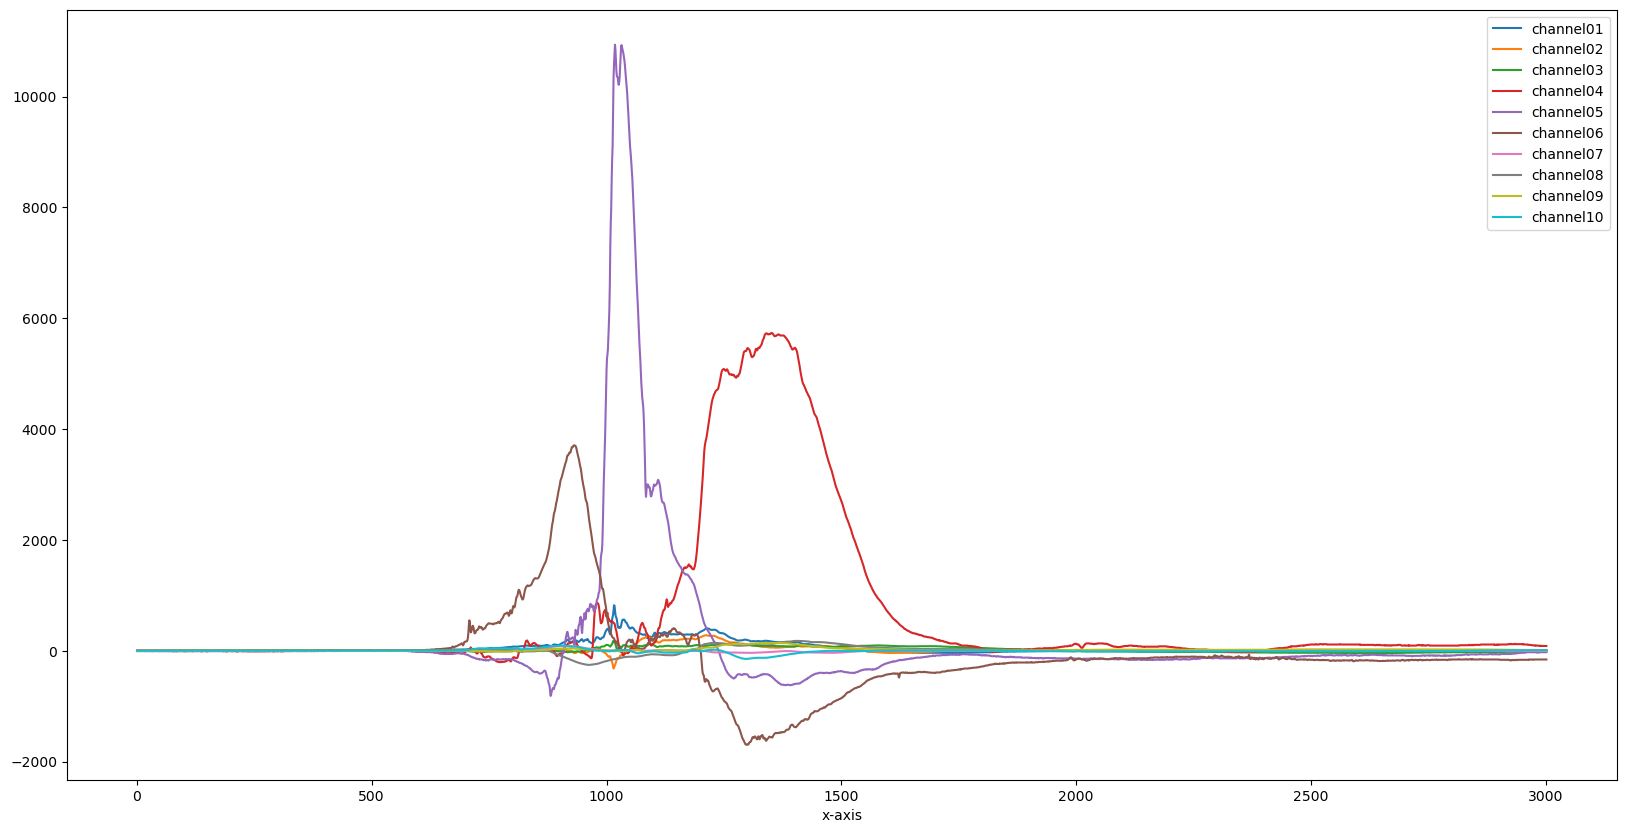

In [9]:
%matplotlib inline
import pandas as pd
import pyspark
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)
pdf = df.toPandas().groupby(["idref", "x-axis"], group_keys=True).sum()
pdf.loc['NVHDEMO_SubMatrix_3'].plot()
plt.show()

Now that your measurement data is in a pandas.DataFrame, you can also use all options using pandas.

Have fun.

## Close the SparkContext
It is a good practice to close the SparkContext when you’re done with it.

This will ensure that all Spark-related operations are properly terminated before your program exits.


In [10]:
sc.stop()

## License

Copyright © 2024 [Peak Solution GmbH](https://peak-solution.de)

The training material in this repository is licensed under a Creative Commons BY-NC-SA 4.0 license. See [LICENSE](../LICENSE) file for more information.